In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

# Part b

In the second part, you will apply some of the preprocessing techniques from part 1. Additionally you will thoroughly check an EMG dataset for possible corruptions. 

The dataset used is an shorter version of a dataset obtained from ninapro. 

After loading the data, we can see that it is a dictionary. The meaning of the keys can be found at https://ninapro.hevs.ch/instructions/DB1.html. Again, before doing anything, we need to know the data.

In essence, the data was acquired through 10 repetitions of 52 different movements (for this particular dataset, there are only 12).   
The subjects are asked to repeat movements which were shown as movies on the screen of a laptop. 

Also, note that these data are already **partially preprocessed.**


TODO: know your data

In [3]:
data = loadmat("exercise_1__dataset_1.mat")
print(f"What kind of data structure are we working with? {type(data)}")
print(f"What are the keys of the data structure? {[key for key in data.keys()]}")

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? ['__header__', '__version__', '__globals__', 'emg', 'restimulus', 'rerepetition']


Exploration of the data: the actual meaningful data lives in the columns ['emg', 'restimulus', 'rerepetition'].   

If we print the shape of the array, 0th dimension of EMG column will correspond to the number of timesteps *n_tsteps*, while the 1st dimension are the different channels of electrodes. 

In [4]:
emg_rectified = data["emg"].copy()

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (101014, 10), 
Stimulus (101014, 1), 
Repetition (101014, 1)


TODO: We also see that there are 12 different types of movement.

In [5]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


Next, let's look at how many samples (a.k.a timesteps) each trial (one combination of stimulation and repeats) has.

In [6]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[305., 354., 346., 371., 438., 372., 430., 412., 435., 352.],
       [193., 388., 233., 234., 244., 252., 316., 227., 229., 302.],
       [524., 390., 481., 433., 460., 515., 199., 360., 424., 356.],
       [348., 296., 287., 276., 281., 242., 278., 315., 330., 329.],
       [452., 453., 382., 416., 376., 418., 430., 339., 318., 368.],
       [293., 305., 432., 286., 301., 306., 254., 299., 253., 329.],
       [246., 240., 266., 263., 252., 187., 259., 325., 299., 278.],
       [211., 294., 277., 359., 333., 372., 374., 287., 306., 185.],
       [197., 250., 234., 222., 295., 281., 269., 330., 289., 241.],
       [458., 184., 184., 270., 407., 188., 338., 379., 473., 306.],
       [186., 285., 305., 195., 230., 240., 222., 318., 238., 272.],
       [341., 429., 189., 239., 526., 261., 185., 521., 224., 319.]])

We can see that the number of samples for each trial is different. This is because of the nature of the task they have to perform.   

The subjects were asked to repeat movements on shown on the screen, however the time taken for each movements can differ: some could be longer than the other. 

It will not be possible to fit it into a tensor (e.g. vector is a 1-dimensional tensor) directly as the size is not the same throughout. 

Therefore, we will be using a nested list to contain and access the data in the subsequent analysis. 

### Window and envelope
Now, lets visualize the data. In this example, we will illustrate using data from a single trial (repetition 1 of stimulus 1) using moving average for detecting the envelope.

In [7]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

Text(0.5, 0.98, 'Envelopes of the EMG signal')

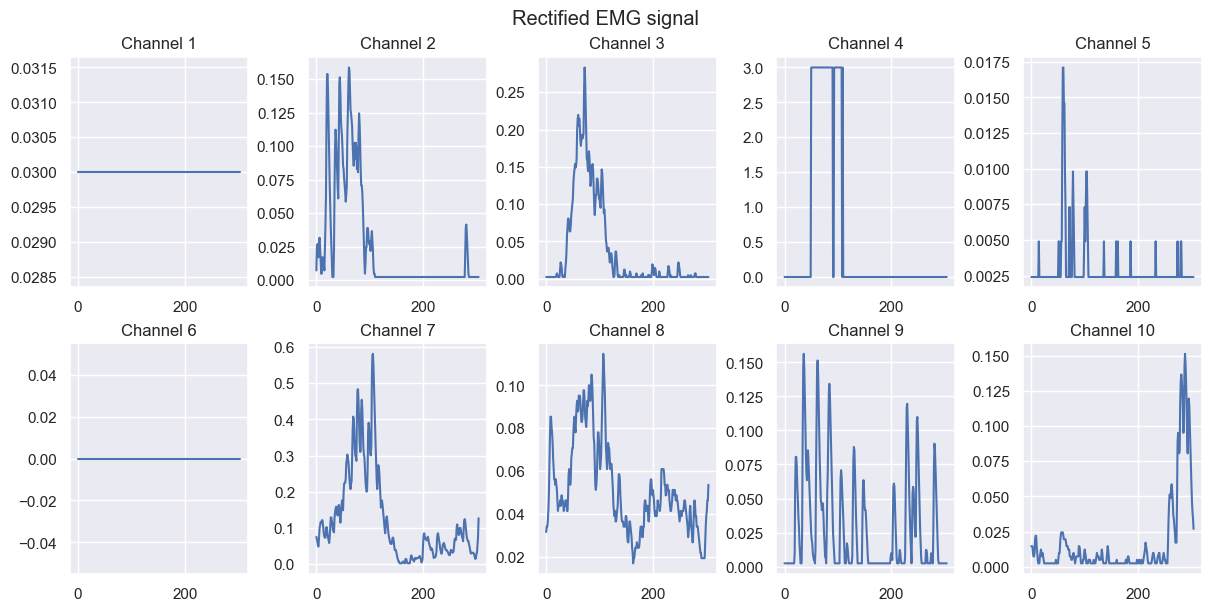

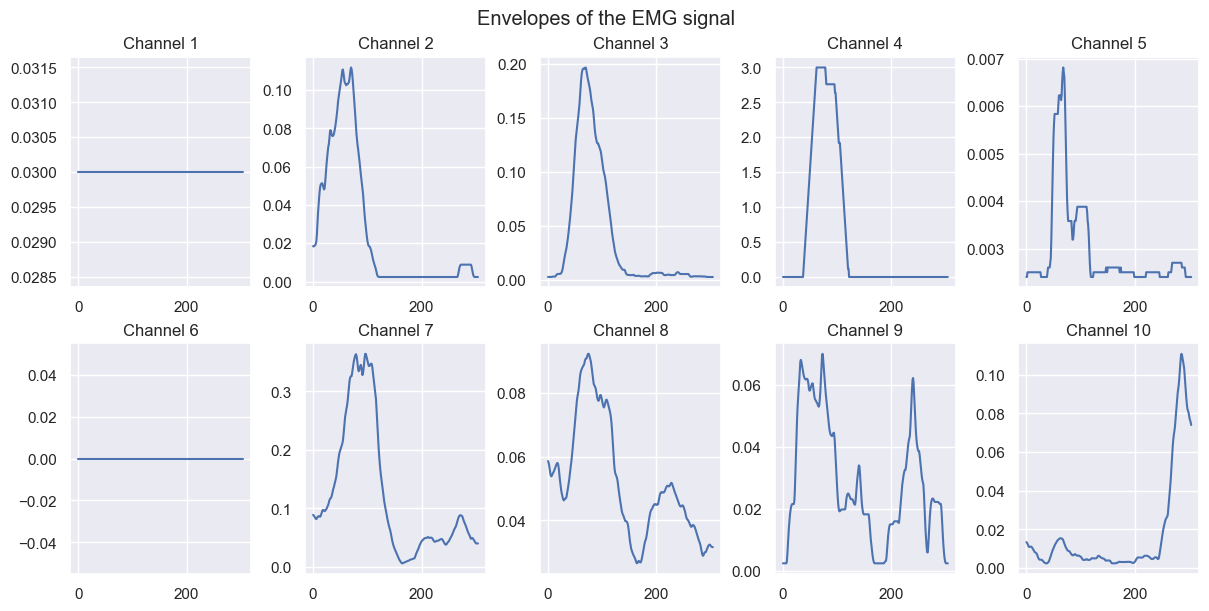

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

#10 EMG channels
number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

From the plots, it seems that we already have the envelopes through moving average although high frequency signals might still be present. 

Note that weird looking plots might occur when using moving average (look at channel 5). Another method that is often used in literature is to use a low pass filter instead of applying the moving average. However, such filtered signals might become partially negative. Running another round of rectification could introduce non-differentiability. Which could affect the subsequent analysis depending on the pipeline.

Moreover, notice that the signals in Channel 1 and Channel 6 are just a constant and 0. It's almost impossible to have perfectly constant EMG signals for a long period of time. 

Clearly there was some issue during the data acquisition process. The data acquisition system could have been disconnected or holding the value constant. 

Depending on how much data you have, you might want to discard that particular trial for further analysis.

Text(0.5, 0.98, 'Envelopes of the EMG signal')

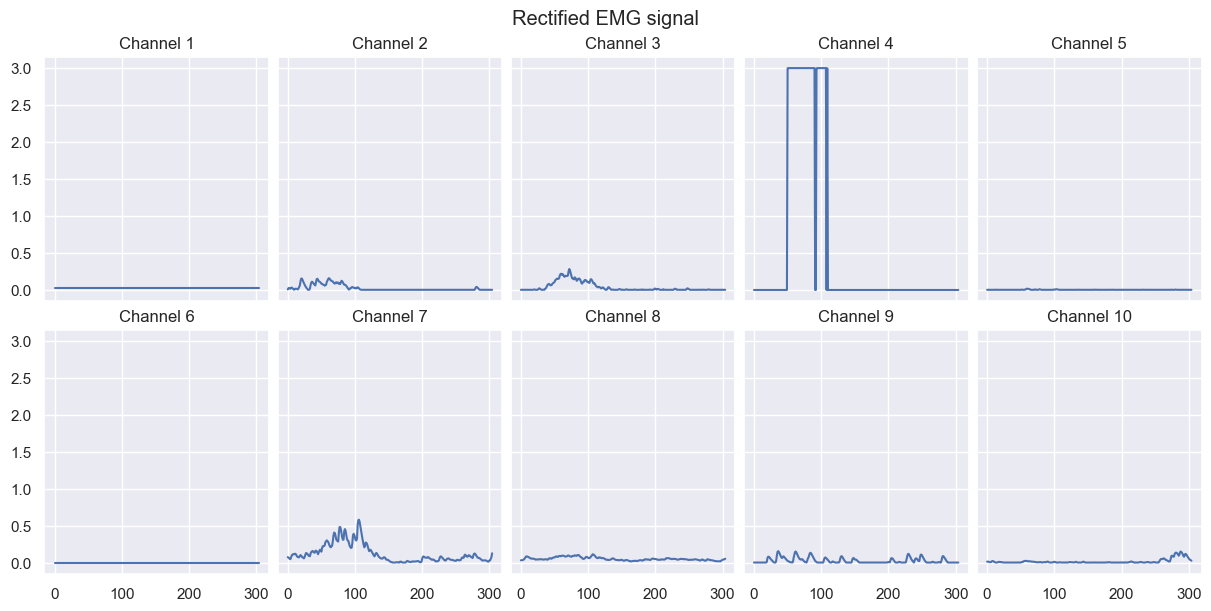

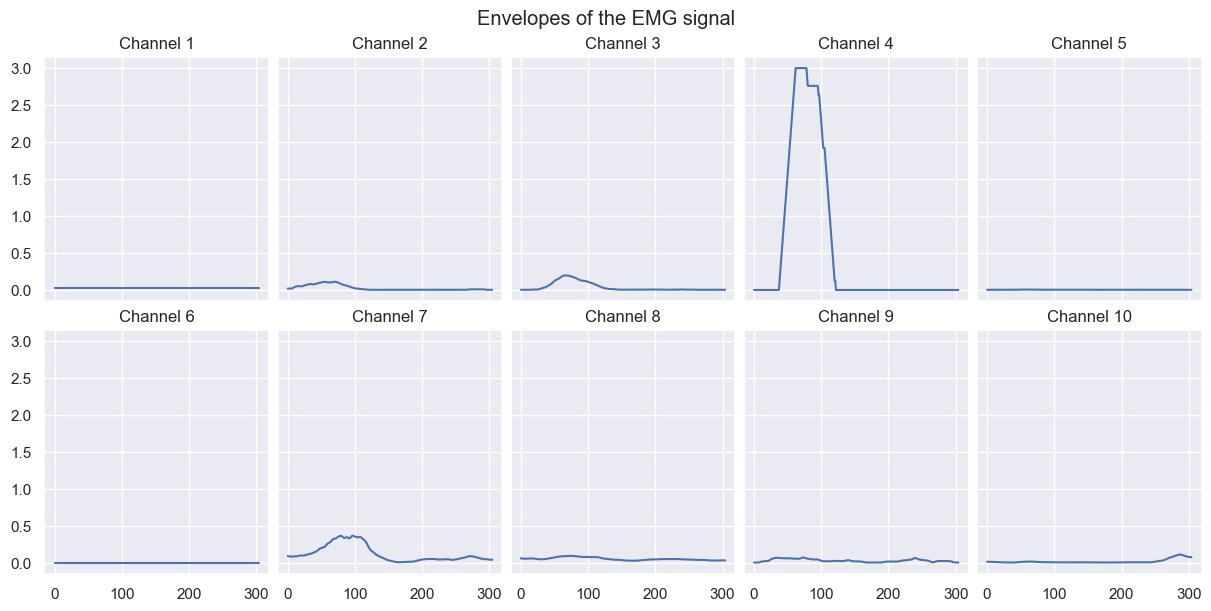

In [9]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Initially when we look at the plots on by their individual y axis, it's easy to miss the anomalies in Channel 4.  

However, if we plot the signals with same axis, we see that the values of Channel 4 is over powering the other channels.   
Also, based on the rectified window signal, it seems to be clipped at 3.0. Such saturation can be due to some electrical noise. 

Same as the rationale above for channel 1 and 6, it is better that we do not consider that trial for analysis as well.

Text(0.5, 0.98, 'Envelopes of the EMG signal')

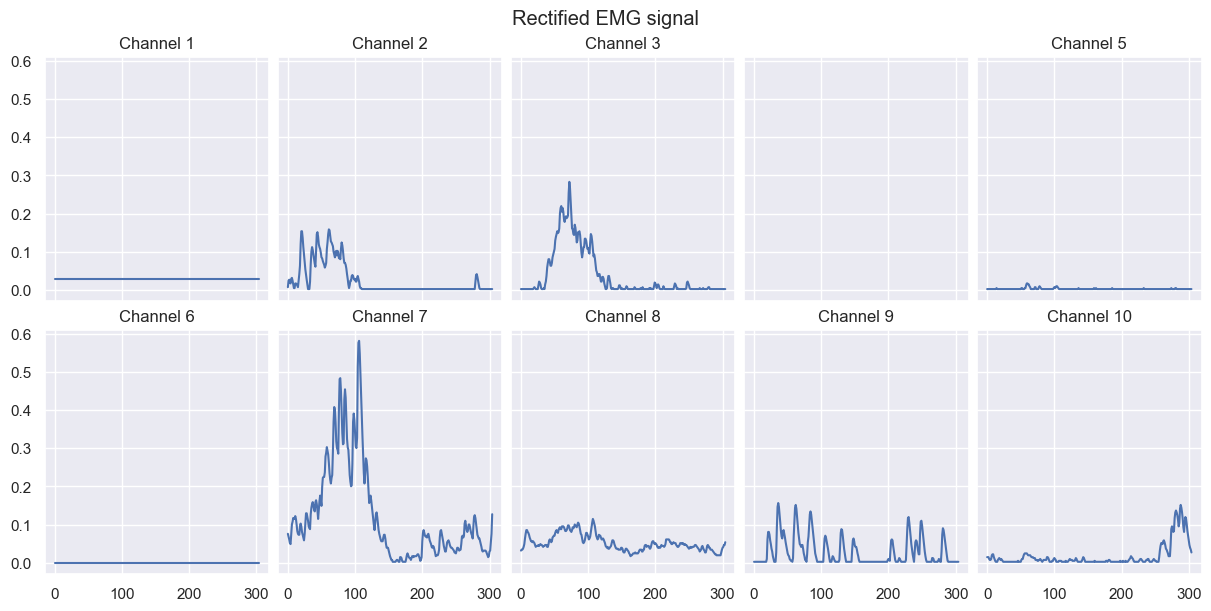

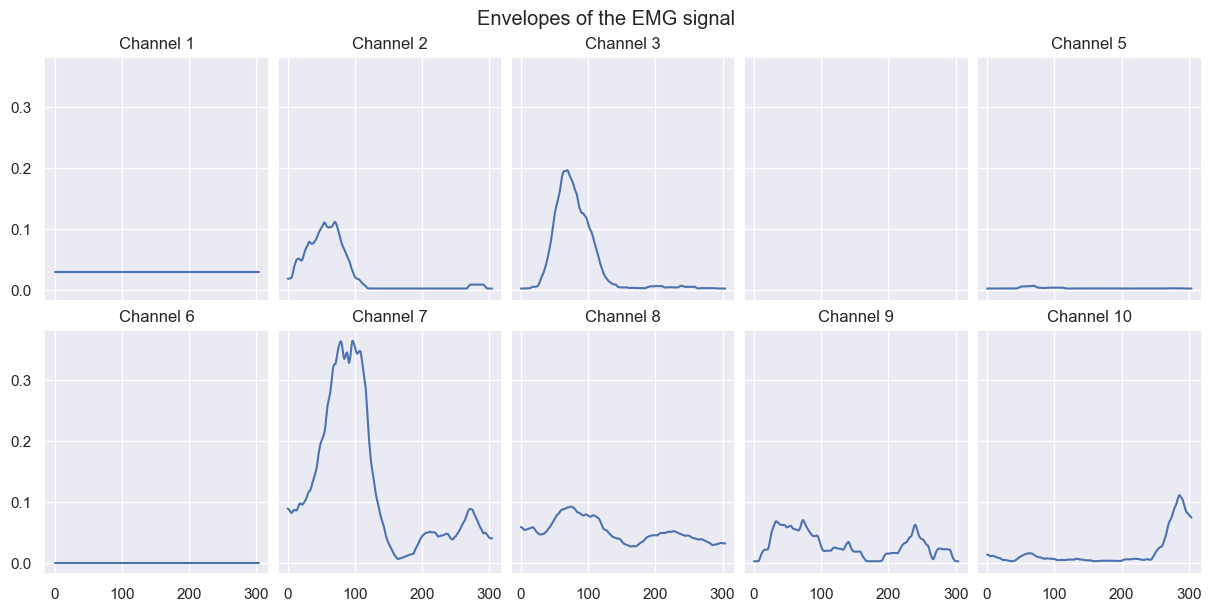

In [10]:
plt.close("all")
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal but skipping channel 4
for channel_idx in range(number_of_emg_channels): 
    if channel_idx == 3:
        continue
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    if channel_idx == 3:
        continue
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Now we see the signals on the same y-scale, channel 2, 3 and 7 seem to capture some activity for this particular movement


### Visualizing across repetitions

Remember that we were only looking at a single trial in the previous section. 

To check for the robustness of the signal, we will generally need to repeat the stimulus multiple times and look at the trend of the signal quality over time.

In [11]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

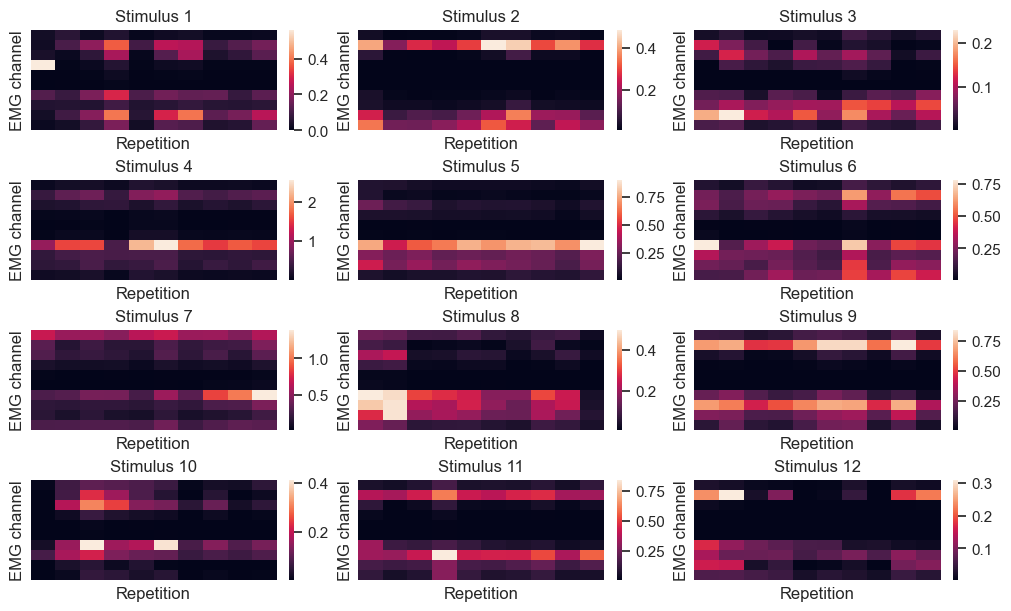

In [12]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

Does the structure seem homogeneous by row? Why?

The rows represent the activity recorded by each channel in response to repeated stimuli. There appears to be a notable homogeneity across the rows, which aligns with expectations. Since each channel is exposed to the same stimulus, it's logical that they would capture similar muscular activities. This consistency suggests that the channels are functioning correctly and are reliably capturing the stimulus-induced activity.

Does the structure seem homogeneous by column? Why?

The columns correspond to each repetition of the stimulus. Variability across columns is expected due to several factors. Firstly, not all muscles are equally activated with each stimulus repetition, leading to differences in the recorded activity. Additionally, the impedance of each channel may vary, affecting the amplitude of the recorded signals. Therefore, the amplitude alone may not be a reliable metric for comparing channel responses. 

What can we say comparing the EMG recordings for different stimuli?

At a preliminary glance, it appears that different stimuli elicit activation in different muscle groups. However, a more thorough analysis is required to confirm this observation. One approach could be to normalize the signals, making them more comparable across channels. This normalization would help in identifying specific patterns of muscle activation unique to each stimulus, providing deeper insights into the neuromuscular responses elicited by different stimuli.